# Properly fit the GPU scaling

## Introduction

My method used to be an asymptotic fit in loglog scale, i.e. a linear fit on the two regimes.  
This method has a few problems:
- fitting the 2nd regime with the 6th point or not changes the slope (from 0.93 to 1.0)
- does not take into account the incertitudes on the points

Let's try to fit all the data at the same time taking into account the incertitudes.

We consider two models:
- a constant + power law (i.e. constant + linear model in log scale)
- two power laws (i.e. two linear models in log scale)

A linear model on log scaled data writes:
$$ \log(y) = a + b\log(x) \Longrightarrow y = \exp(a + b\log(x)) = e^a b^x $$
Thus with $a' = e^a$, we have
$$ y = a x^b $$
which is a power law.

Despite what would seem logical, we cannot add two models in log scale without encoutering problems with the sum of the log. Thinking in linear scale is probably simpler.  
Therefore, the two aformentionned model write
- $y_1 = a + b x^c$
- $y_2 = a x^b + c x^d$

## Data loading, linear plot and model definition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
data = pd.read_csv("gpu_timings.csv")
data["nnode"] = data["size"] ** 2
data

,size,mean,std,nnode
0,51,0.002539,0.000032,2601
1,101,0.002863,0.000031,10201
2,121,0.002961,0.000032,14641
3,201,0.002939,0.000069,40401
4,301,0.003080,0.000203,90601
5,401,0.003581,0.000276,160801
6,601,0.005925,0.001037,361201
7,801,0.009374,0.001175,641601
8,1001,0.014535,0.001319,1002001
9,1501,0.032611,0.001405,2253001


Text(0, 0.5, 'Execution time [s]')

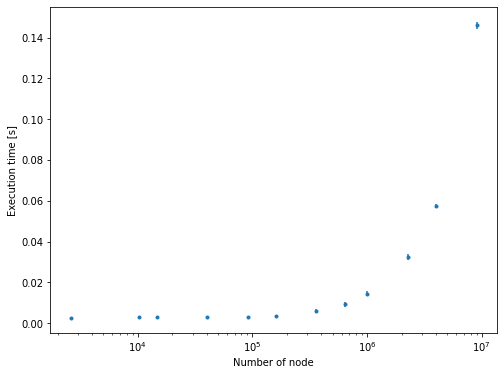

In [4]:
plt.figure(figsize=(8,6))
plt.errorbar(data["nnode"], data["mean"], data["std"], fmt=".")

plt.semilogx()
plt.xlabel("Number of node")
plt.ylabel("Execution time [s]")

Let's define our models:

In [5]:
def power_law(x, a, b):
    return a * (x**b)

def cst_plus_power_law(x, a, b, c):
    return a + power_law(x, b, c)

def two_power_law(x, a, b, c, d):
    return power_law(x, a, b) + power_law(x, c, d)

def lin_model(x, a, b):
    return a + b*x

## Fit in linear space

In [6]:
# Extracting data
x = data["nnode"]
y = data["mean"]
err_y = data["std"]

In [7]:
# Initial guess from asymptotic linear fits on each regime
lim1 = 5
lim2 = -5
init1, pcov_init1 = curve_fit(lin_model, x[:lim1], y[:lim1])
init2, pcov_init2 = curve_fit(lin_model, x[lim2:], y[lim2:])

In [8]:
init1, np.sqrt(np.diag(pcov_init1))/init1

(array([2.74597796e-03, 4.11608020e-09]), array([0.03714615, 0.54958855]))

In [9]:
slope1, constant1 = init1
slope2, constant2 = init2

In [10]:
popt_model, pcov_model = curve_fit(cst_plus_power_law, x, y, 
                                   sigma=err_y, p0=[constant1, constant2, slope2])

In [11]:
popt_model, np.sqrt(np.diag(pcov_model))/popt_model

(array([2.73209807e-03, 1.18165150e-09, 1.16198045e+00]),
 array([0.02033176, 0.79565657, 0.04387686]))

Text(0, 0.5, 'Execution time [s]')

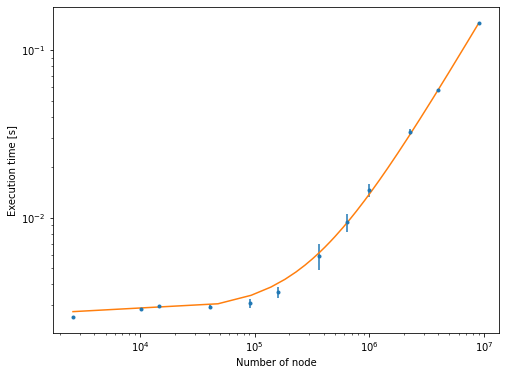

In [12]:
x_plot = np.linspace(x.min(), x.max(), 200)
plt.figure(figsize=(8,6))
plt.errorbar(data["nnode"], data["mean"], data["std"], fmt=".")
#plt.plot(x_plot, lin_model(x_plot, *init1))
#plt.plot(x_plot, lin_model(x_plot, *init2))
plt.plot(x_plot, cst_plus_power_law(x_plot, *popt_model))

plt.loglog()
plt.xlabel("Number of node")
plt.ylabel("Execution time [s]")

## Fit in log space

In [33]:
x = np.log10(data["nnode"])
y = np.log10(data["mean"])
err_y = np.log(data["std"])

In [34]:
# Init with asymptotic fits
init1, pcov_init1 = curve_fit(lambda x, a, b : np.log10(lin_model(10**x, a , b)), x[:lim1], y[:lim1])
init2, pcov_init2 = curve_fit(lambda x, a, b : np.log10(lin_model(10**x, a , b)), x[lim2:], y[lim2:])

In [35]:
init1, np.sqrt(np.diag(pcov_init1))/init1

(array([2.73643042e-03, 4.32956669e-09]), array([0.03813867, 0.5745404 ]))

In [36]:
slope1, constant1 = init1
slope2, constant2 = init2

In [37]:
popt_log1, pcov_log1 = curve_fit(
    lambda x, a, b, c: np.log10(cst_plus_power_law(10**x, a, b, c)),
    x, y, sigma=err_y, p0=[constant1, constant2, slope2]
)

In [38]:
popt_log1, np.sqrt(np.diag(pcov_log1))/popt_log1

(array([2.60863092e-03, 1.09369694e-09, 1.16839619e+00]),
 array([0.03537997, 0.34267203, 0.01978456]))

Text(0, 0.5, 'Execution time [s]')

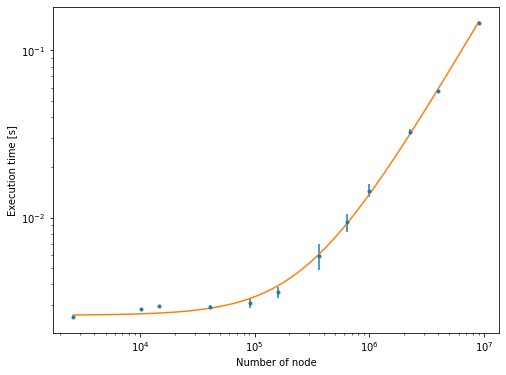

In [39]:
x_plot = np.logspace(x.min(), x.max(), 200)
plt.figure(figsize=(8,6))
plt.errorbar(data["nnode"], data["mean"], data["std"], fmt=".")
#plt.plot(x_plot, lin_model(x_plot, *init1))
#plt.plot(x_plot, lin_model(x_plot, *init2))
plt.plot(x_plot, cst_plus_power_law(x_plot, *popt_log1))

plt.loglog()
plt.xlabel("Number of node")
plt.ylabel("Execution time [s]")